In [16]:
from bs4 import BeautifulSoup
from requests import get

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

import time
import re
import os
from pathlib import Path

Before we start scraping Wikipedia, we have to define some constants for our scraper. Scraping Wikipedia is suprisingly easy, the DOM tree and class names are very consistent. Despite this, Wikipedia still has a lot of garbage links that we don't want. This is where we define all of our rules for what counts as a "bad" link.  Examples of bad links include images, self links, internal links (links to enlarge photos, believe it or not), or invisible links that take you to the top of the page.

One might think to simply filter by links containing `/wiki/`, but even those links aren't safe. Indeed Wikipedia contains various different types of internal `/wiki/` links that point to various medias, template pages, or help files, which we are not interested in. We also filter them here.

In [17]:
DATA_DIR = 'data'
GRAPH_FILENAME = 'wiki_graph'

# we filter out these types of link selectors
CLEAN = [
  'a[id="top"]',
  'a[class="mw-selflink selflink"]',
  'a[class="image"]',
  'a[class="internal"]',
]

# we filter out these links
REM_LINKS = [
  r"(\/wiki\/File:\w+)",
  r"(\/wiki\/Special:\w+)",
  r"(\/wiki\/Template:\w+)",
  r"(\/wiki\/Category:\w+)",
  r"(\/wiki\/Portal:\w+)",
  r"(\/wiki\/Template_talk:\w+)",
  r"(\/wiki\/Help:\w+)",
  r"(\/wiki\/Wikipedia:\w+)",
  r"(^#\w+)",
]

# main page content selector
CONT_SEL = "div#content"

Here, we load the list of pages that we are interested in scraping

In [18]:
# load most popular wikipedia pages csv
df = pd.read_csv(f"{DATA_DIR}/top1000.csv")

# get a list of pages as an array of strings
urls = df['article'].to_numpy().astype(str)

# filter the pages to only articles without ':' in the title
# I know this may not cover everything, but I'm just testing here
urls = urls[np.char.find(urls, ':') == -1]

# Download the Pages Locally

To avoid overwhelming Wikipedia we download every page, unmodified, locally. This allows us to fail multiples times without Wikipedia having to know about it. This is also much faster since we are working with local files. The reason we leave the files unmodified here instead of cleaning them at the same time is that we always want to have the maximum amount of information possible first (in case you need it) and clean it up as a separate step.

One thing to note here is that we also add a variable `START_INDEX` to manually start from a particular index in our list of links to scrape. This serves two purposes. The first is in case a special page break our code, we don't have to restart from the beginning to rescrape the pages we already have. The second is for this page not to take 50 hours to compile to HTML.

In [19]:
# in case you wanna skip ahead
START_INDEX = 970
SLEEP_TIME_S = 2 # dont make less than 2, we dont wanna overwhelm wikipedia too much

n = urls.size

# compile the title cleanup regex for optimization
title_re = re.compile(r"\/")

for i, url in enumerate(urls):
  if i < START_INDEX:
    continue

  print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Scraping {url}")

  # load the page as html with BeautifulSoup
  res = get(f'https://en.wikipedia.org/wiki/{url}')

  # check if we got baned :c
  if res.status_code != 200:
    print("We got got")
    break

  html = BeautifulSoup(res.text, 'html.parser')

  # save html page as string
  html_str = str(html.prettify())

  # replace bad characters in titles with underscores
  title = title_re.sub("_", url)

  # save file
  f = open(f"{DATA_DIR}/pages/{title}.html", "w")
  f.write(html_str)
  f.close()

  # let's not overload wikipedia with requests here
  time.sleep(SLEEP_TIME_S)

# Building the Graph

Here we use our local data and our filters defined above to build our page connections graph with `networkx`. We itterate through each page in our local file structure and, for each page we look at each link that matches our filters defined in our constants above. Note that we don't add every url that passes our filter here, _we only add an edge if its destination page is also in our list of pages_.

In [20]:
files = os.scandir(path = f"./{DATA_DIR}/pages/")
n = len(list(files))

In [21]:
G = nx.DiGraph()

# list our downloaded files
files = os.scandir(path = f"./{DATA_DIR}/pages/")
# n = len(list(files))

for i, file in enumerate(files):
  # extract url from filename
  url = Path(file).stem

  print(f"{i} of {n} ({round((i / n) * 100, 2)}%) - Graphing {url}")

  # add the current page to the graph
  G.add_node(url)

  # load the page into memory
  f = open(file, "r")
  html = BeautifulSoup(f.read(), 'html.parser')
  f.close()

  # clean up unwanted elements from page
  for c in CLEAN:
    els = html.select(f"{CONT_SEL} {c}")
    for el in els:
      el.decompose()

  # further remove unwanted links
  links = html.select(f"{CONT_SEL} a")
  for link in links:
    # extract href from link
    href = link['href']

    # we are only interested in links that start with `/wiki/` and aren't in REM_LINKS
    if not any([re.match(regex, href) for regex in REM_LINKS]) and re.match(r"^\/wiki\/\w+", href):
      # extract href from link
      href = link['href']

      # this is the destination url
      url_ = re.sub(r"\/wiki\/", "", href)

      # we only add the destination url if it happens to be inside our links of interests
      if url_ in urls:
        # add edge to graph
        G.add_edge(url, url_)

  # save our graph at other file
  if i % 3 == 0:
    nx.write_gml(G, f"{DATA_DIR}/{GRAPH_FILENAME}.gml")

0 of 10 (0.0%) - Graphing 1337x
1 of 10 (10.0%) - Graphing Battle_of_Kharkiv_(2022)
2 of 10 (20.0%) - Graphing Bruce_Willis_filmography
3 of 10 (30.0%) - Graphing Jimmy_Carter
4 of 10 (40.0%) - Graphing Monaco
5 of 10 (50.0%) - Graphing Patrick_Swayze
6 of 10 (60.0%) - Graphing Salman_Khan
7 of 10 (70.0%) - Graphing Sue_Bird
8 of 10 (80.0%) - Graphing Sweden
9 of 10 (90.0%) - Graphing West_Side_Story_(1961_film)


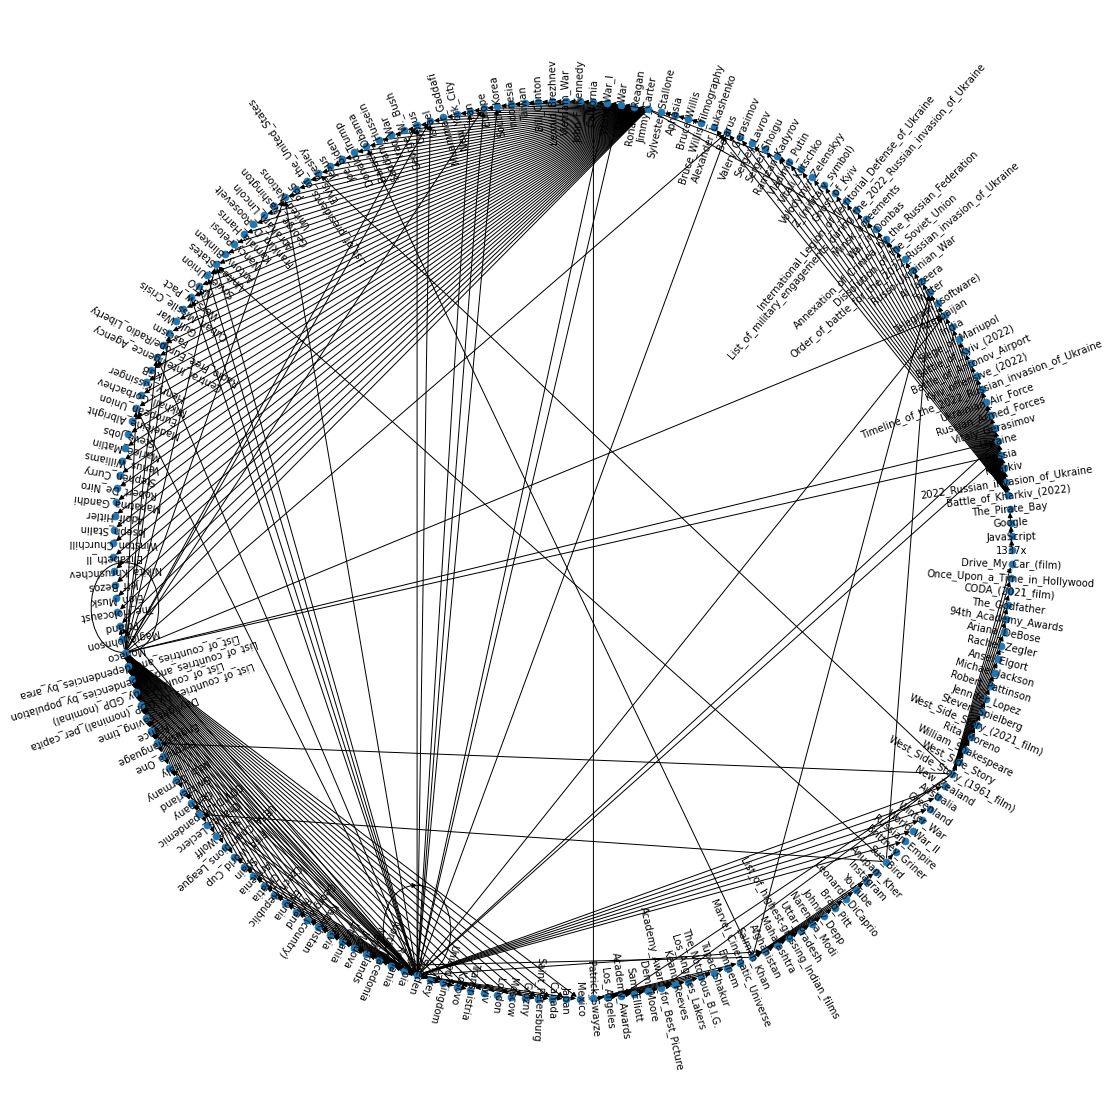

In [68]:
nodes = np.array(G.nodes)

sub_nodes = np.random.choice(nodes, size = 25)
sub_nodes

fig, ax = plt.subplots(figsize=(20, 20))

nodes = (G.nodes)
N_nodes = G.number_of_nodes()

pos = nx.circular_layout(G)

# Setting up the text by using node position 
texts=[plt.text(pos[node][0],pos[node][1],str(node),rotation=(i/N_nodes)*360, fontsize=10,horizontalalignment='center',verticalalignment='center') for i, node in enumerate(nodes)]

nx.draw(G, pos=pos, arrows=True, node_size=50, linewidths=0.6, ax=ax)
ax.set_aspect('equal')
plt.show()